In [93]:
import os
print (os.getcwd())
import seaborn
import pandas


/home/cpu/git/cpu/study/diploma/code


In [94]:

# Find differences between files pipeline
from pipeline_clean import CleanPipeline
cpp = CleanPipeline()
cpp.process()
cpp.maping

{'data/Воспл. 4500355000-01 № 095/2014_04_03 Воспл. 4500355000-01 № 095/2/protA3.rtf': 'В воздухоподводящем отверстии установлено 9 проволок: из,них 8 штук d=1,5 мм., и 1 штука d=1мм.',
 'data/Воспл. 4500355000-01 № 095/2014_04_03 Воспл. 4500355000-01 № 095/1/protA3.rtf': 'В воздухоподводящем отверстии установлено 10 проволок: из,них 9 штук d=1,5 мм., и 1 штука d=1мм.',
 'data/Воспл. 4500355000-01 № 095/2014_04_07 Воспл. 4500355000-01 № 095/protA3.rtf': 'В воздухоподводящем отверстии установлено 9 проволоктd=1,5,мм.',
 'data/Воспл. 4500355000-01 № 095/2014_03_25 Воспл. 4500355000-01 № 095/protA3.rtf': 'В воздухоподводящем отверстии установлено 5 проволоки,d=1,5 мм.',
 'data/Воспл. 4500355000-01 № 095/2014_03_31 Воспл. 4500355000-01 № 095/protA3.rtf': 'В воздухоподводящем отверстии установлено 10 проволок,d=1,5 мм.',
 'data/Воспл. 4500355000-01 № 095/2014_03_20 Воспл. 4500355000-01 № 095/2/protA3.rtf': 'В воздухоподводящем отверстии установлено 4 проволоки,d=1,5 мм.',
 'data/Воспл. 4500

In [95]:
from pipeline_data import DataPipeline
from abstracts import ModelContext
from constants import MODEL_CLASSES

ppl = DataPipeline()
ppl.load()
ppl.split()
print (len(ppl.train_data))

ctx = ModelContext(classes=MODEL_CLASSES, train_data=ppl.train_data, val_data=ppl.val_data)
ctx.restore()

246


/home/cpu/git/cpu/study/.venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 



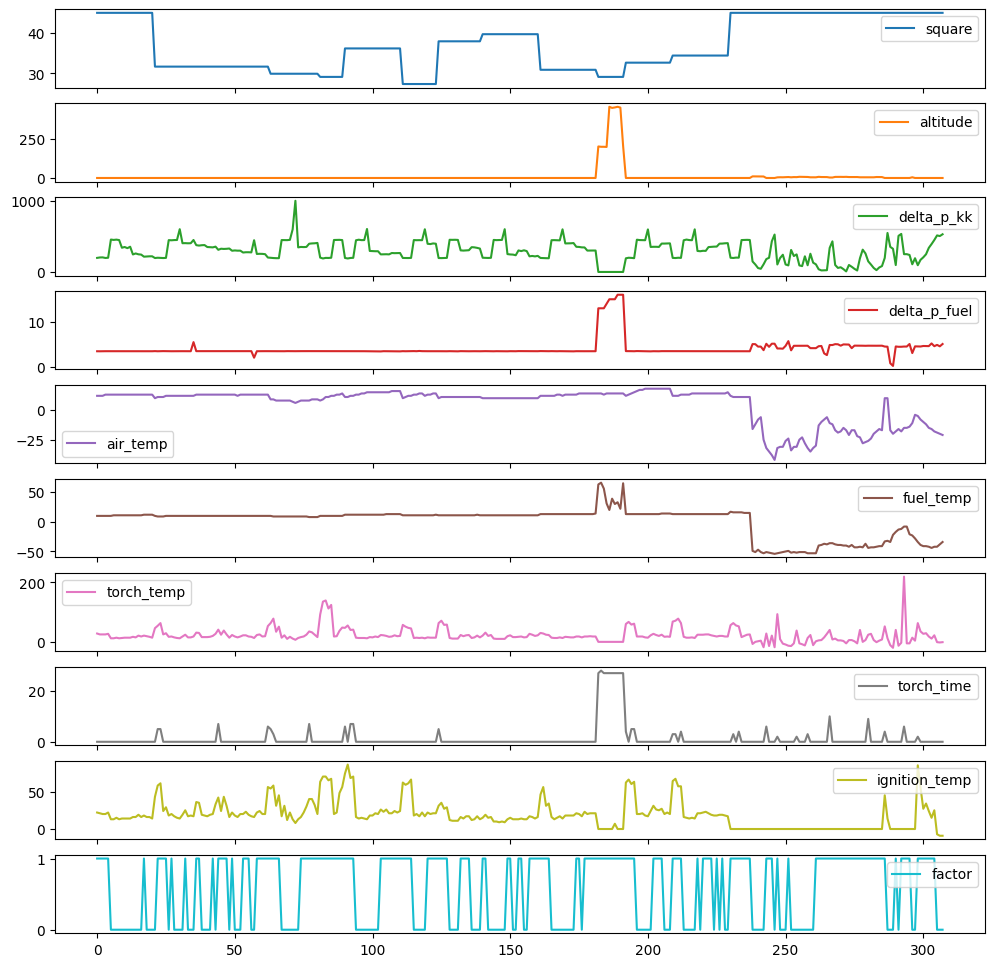

In [96]:
from matplotlib import pyplot
import pandas
data_frame = pandas.DataFrame(ppl.raw_data)
plot_data_frame = data_frame[data_frame.columns]
_ = plot_data_frame.plot(subplots=True, figsize=(12, 12), legend=True)
pyplot.savefig('dataset.png')

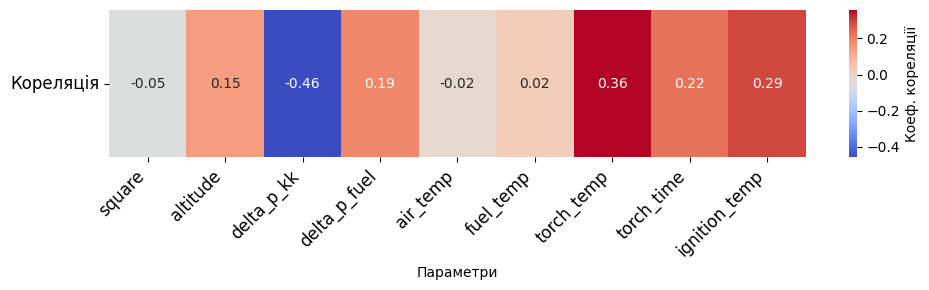

In [97]:
correlation_with_factor = data_frame.corr()['factor'].drop('factor')
correlation_df = correlation_with_factor.to_frame(name='Кореляція').reset_index()
correlation_df.rename(columns={'index': 'Параметри'}, inplace=True)
pyplot.figure(figsize=(10, 3))  
ax = seaborn.heatmap(correlation_df.set_index('Параметри').T, annot=True,
                     cmap='coolwarm', fmt=".2f", cbar=True)
cbar = ax.collections[0].colorbar
cbar.set_label('Коеф. кореляції', rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
pyplot.tight_layout()
pyplot.savefig('corelation-heat-map.png')

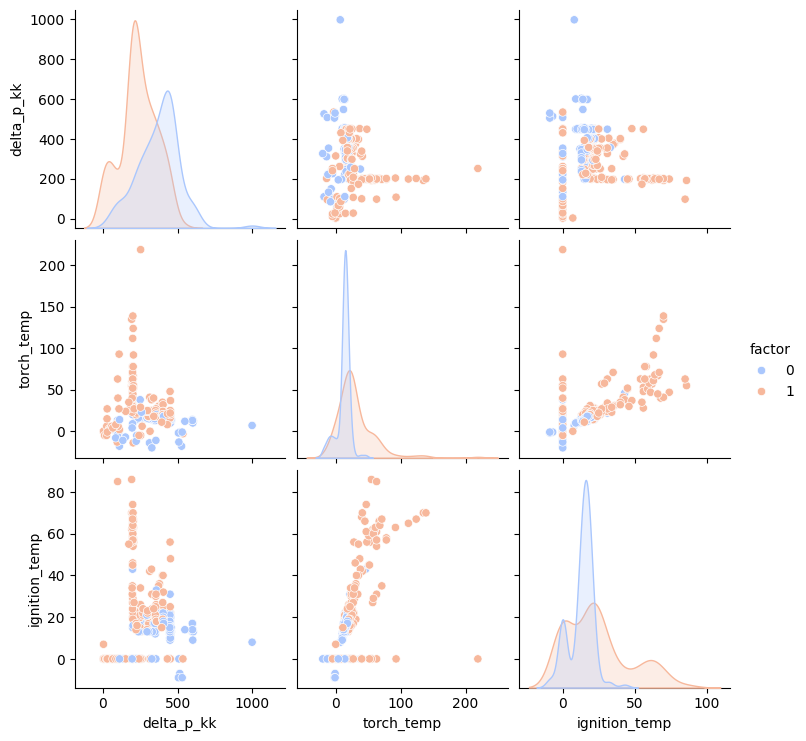

In [98]:
data_frame['factor'] = data_frame['factor'].astype('category')
seaborn.pairplot(data_frame, vars=['delta_p_kk', 'torch_temp', 'ignition_temp'], hue='factor', diag_kind='kde', palette='coolwarm')
pyplot.savefig('pair-plot.png')

In [99]:
features = ppl.raw_data[0].keys()
linear_regression = ctx.strategies[0].model
print (linear_regression)
intercept = linear_regression.intercept_[0]  # Интерсепт
coefficients = linear_regression.coef_[0]
print("Полиномиальная модель:")
print(f"z = {intercept:.2f} " + " + ".join([f"{coeff:.2f}*{feature}" for coeff, feature in zip(coefficients, features)]))


LogisticRegression(C=0.01, l1_ratio=0.01, penalty='l1', random_state=42,
                   solver='liblinear')
Полиномиальная модель:
z = 0.00 0.01*square + 0.01*altitude + -0.01*delta_p_kk + 0.00*delta_p_fuel + -0.00*air_temp + -0.00*fuel_temp + 0.06*torch_temp + 0.00*torch_time + 0.02*ignition_temp


In [100]:
gaussian_naive = ctx.strategies[1].model
priors = gaussian_naive.class_prior_
theta = gaussian_naive.theta_
print (f'Априорные вероятности классов: {priors[0]:.2f} - горить, {priors[1]:.2f} - не горить')
print ('Средние значения признаков для класса - горить')
for coeff, feature in zip(gaussian_naive.theta_[0], features):
     print (f'{feature}: {coeff:.2f}')
print ('Средние значения признаков для класса - не горить')
for coeff, feature in zip(gaussian_naive.theta_[1], features):
     print (f'{feature}: {coeff:.2f}')


Априорные вероятности классов: 0.43 - горить, 0.57 - не горить
Средние значения признаков для класса - горить
square: 37.14
altitude: 0.95
delta_p_kk: 373.39
delta_p_fuel: 3.61
air_temp: 5.59
fuel_temp: 0.21
torch_temp: 12.33
torch_time: 0.05
ignition_temp: 13.20
Средние значения признаков для класса - не горить
square: 36.48
altitude: 19.69
delta_p_kk: 238.30
delta_p_fuel: 4.43
air_temp: 4.95
fuel_temp: 1.13
torch_temp: 30.39
torch_time: 2.35
ignition_temp: 24.73


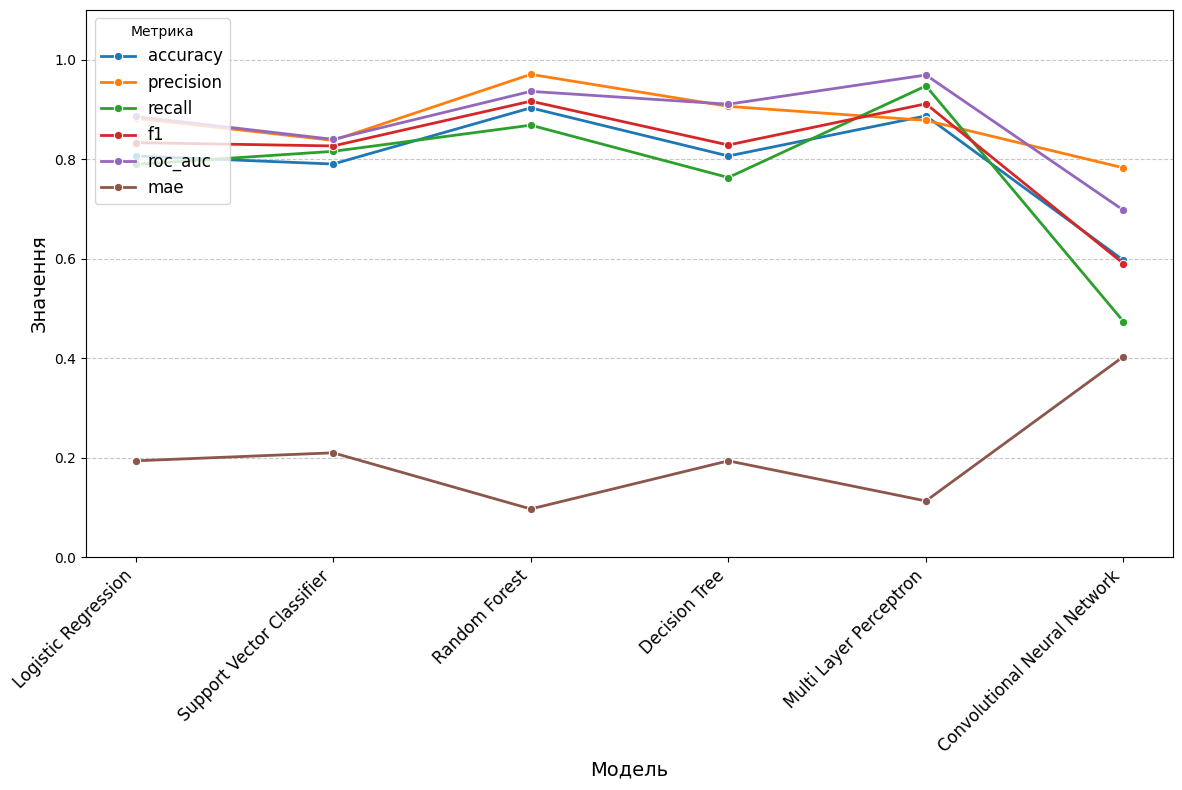

In [101]:
result = dict()
for strategy in ctx.strategies:
    x = strategy.metrics
    row = {
        'accuracy': x['accuracy'],
        'precision': x['precision'],
        'recall': x['recall'],
        'f1': x['f1'],
        'roc_auc': x['roc_auc'],
        'mae': x['mae'],
    }
    if not x['overfit']:
        result[strategy.model_name] = (row)


data_frame =pandas.DataFrame(result).T
df_melted = data_frame.reset_index().melt(id_vars='index', var_name='Metric', value_name='Value')
df_melted.rename(columns={'index': 'Model'}, inplace=True)

pyplot.figure(figsize=(12, 8))
seaborn.lineplot(data=df_melted, x='Model', y='Value', hue='Metric', marker='o', linewidth=2)

pyplot.ylabel('Значення', fontsize=14)
pyplot.xlabel('Модель', fontsize=14)
pyplot.xticks(rotation=45, ha='right', fontsize=12)
pyplot.ylim(0, 1.1)
pyplot.grid(axis='y', linestyle='--', alpha=0.7)
pyplot.legend(title='Метрика', fontsize=12, loc='upper left')
pyplot.tight_layout()
pyplot.savefig('mtrics-plot.png')

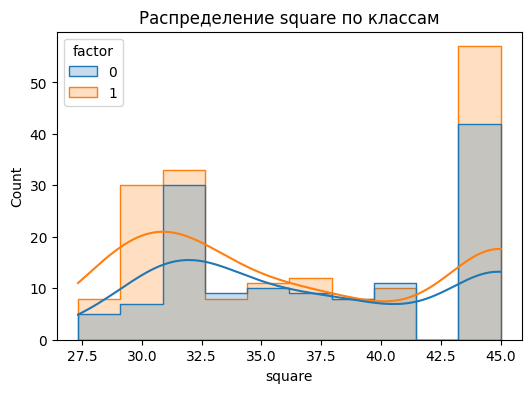

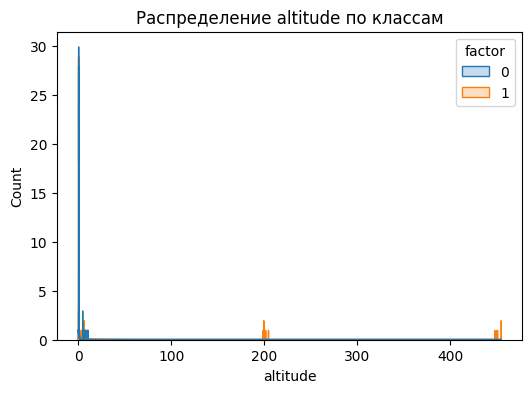

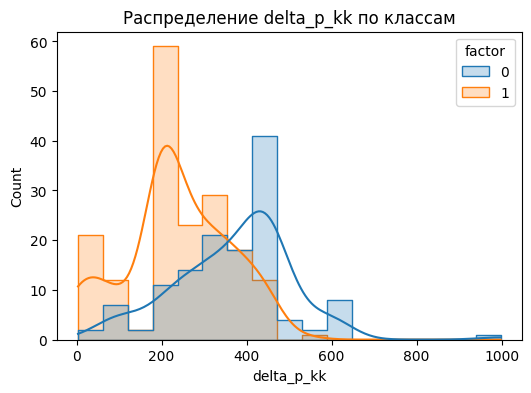

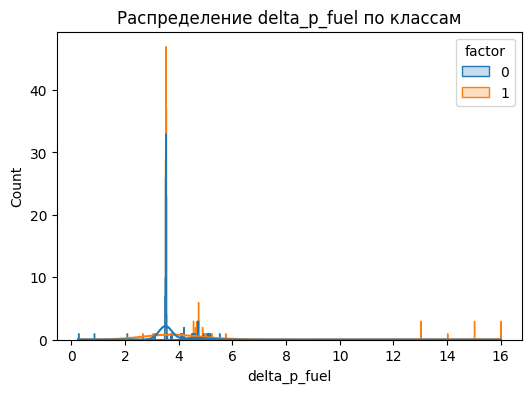

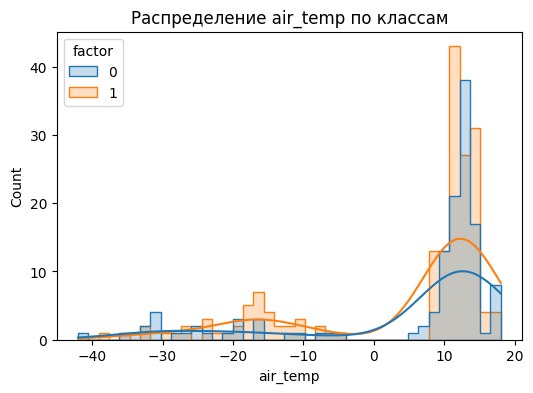

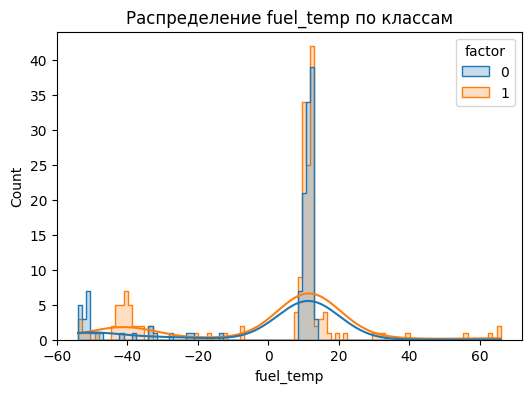

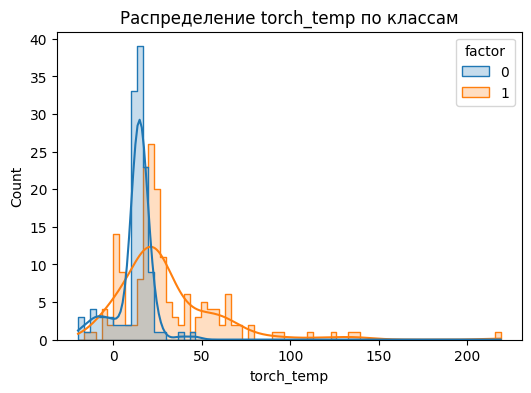

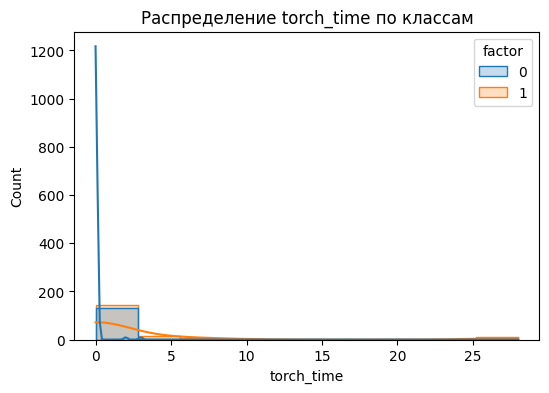

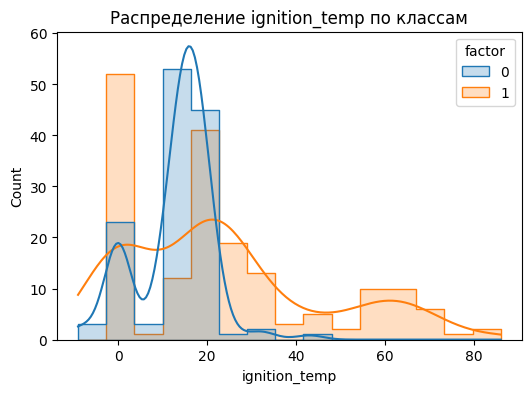

In [104]:

data_frame = pandas.DataFrame(ppl.raw_data)
for col in data_frame.columns[:-1]:
    pyplot.figure(figsize=(6,4))
    seaborn.histplot(data=data_frame, x=col, hue='factor', kde=True, element='step')
    pyplot.title(f'Распределение {col} по классам')
    pyplot.show()

Boxplot / Violinplot Чтобы увидеть, есть ли выбросы или насколько распределения «сжатые».


В этом случае:

    Ось X — классы (0 или 1)
    Ось Y — значения признака.
    Boxplot покажет средние значения, квартили, выбросы.

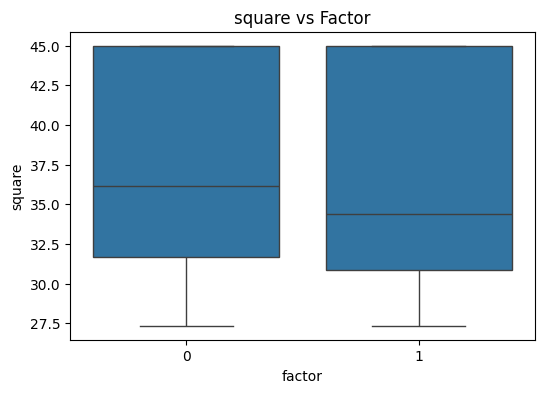

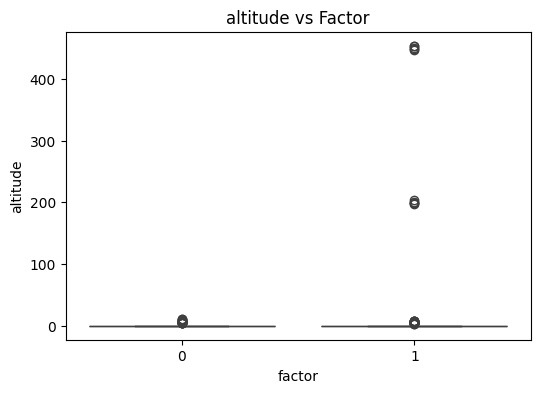

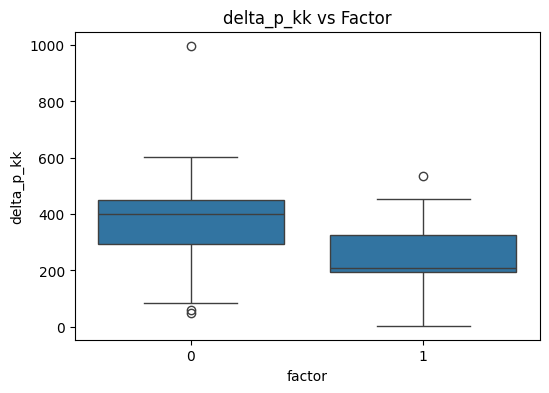

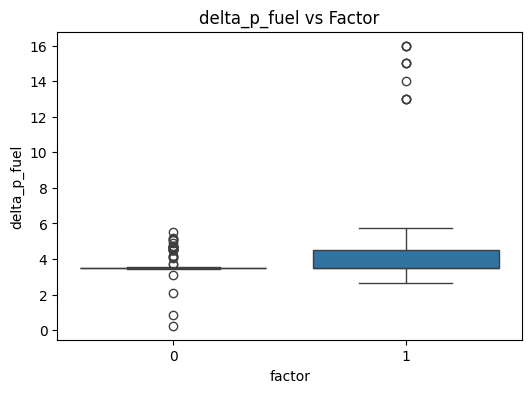

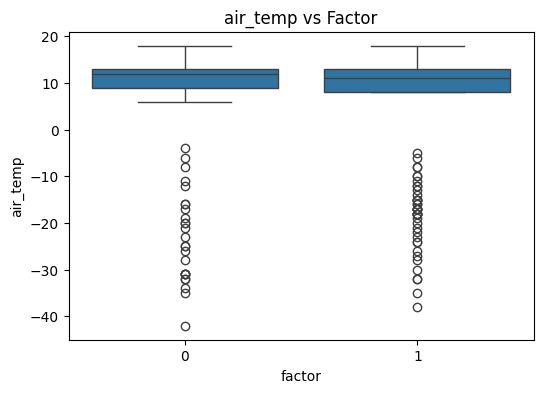

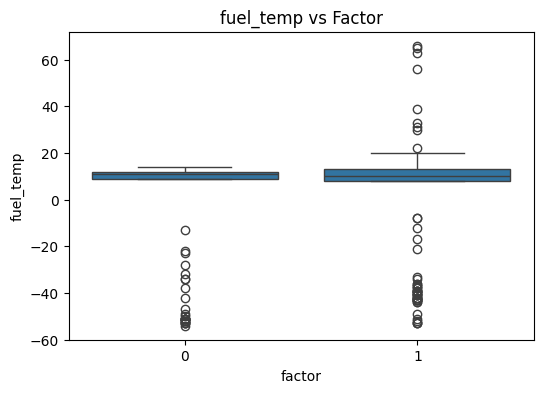

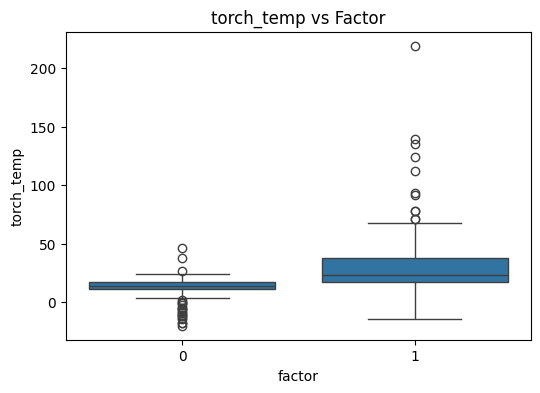

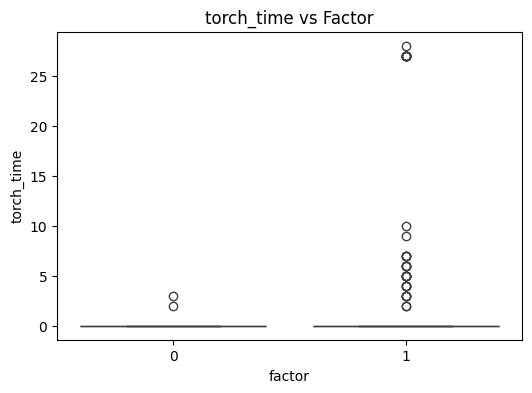

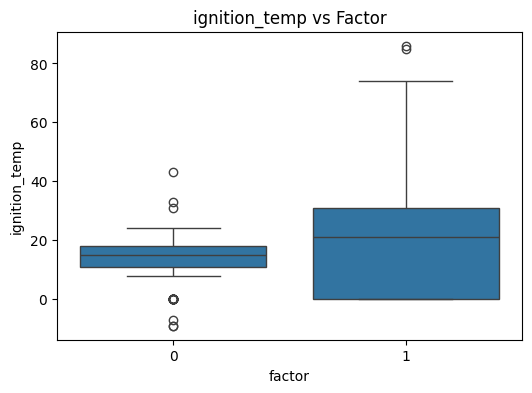

In [105]:
for col in data_frame.columns[:-1]:
    pyplot.figure(figsize=(6,4))
    seaborn.boxplot(data=data_frame, x='factor', y=col)
    pyplot.title(f'{col} vs Factor')
    pyplot.show()

Корреляционная матрица

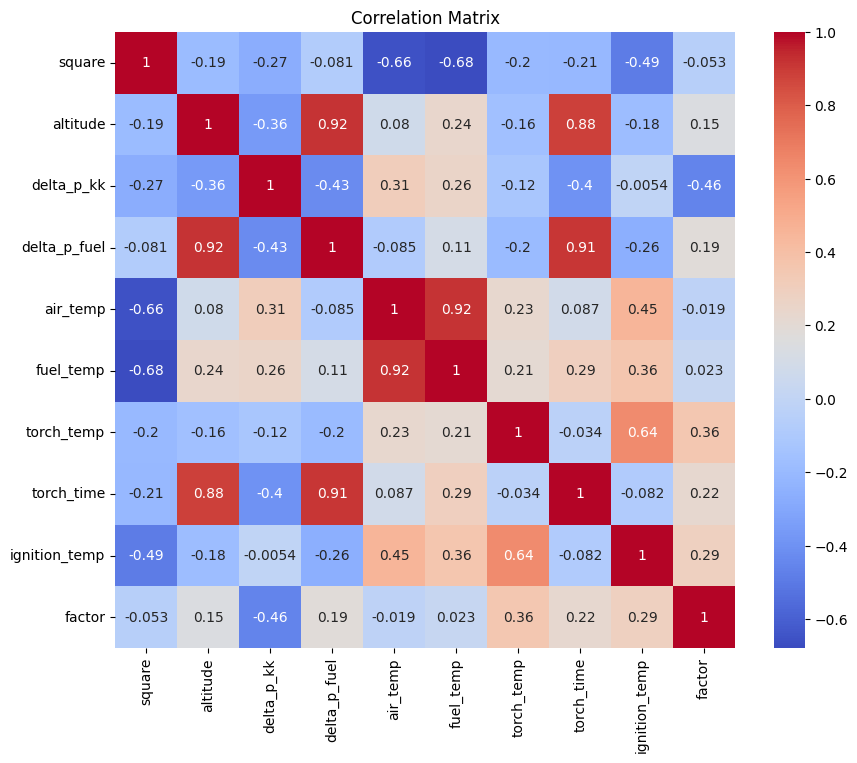

In [106]:
corr_matrix = data_frame.corr()
pyplot.figure(figsize=(10, 8))
seaborn.heatmap(corr_matrix, annot=True, cmap='coolwarm')
pyplot.title('Correlation Matrix')
pyplot.show()

pairplot (каждая фича против каждой фичи)

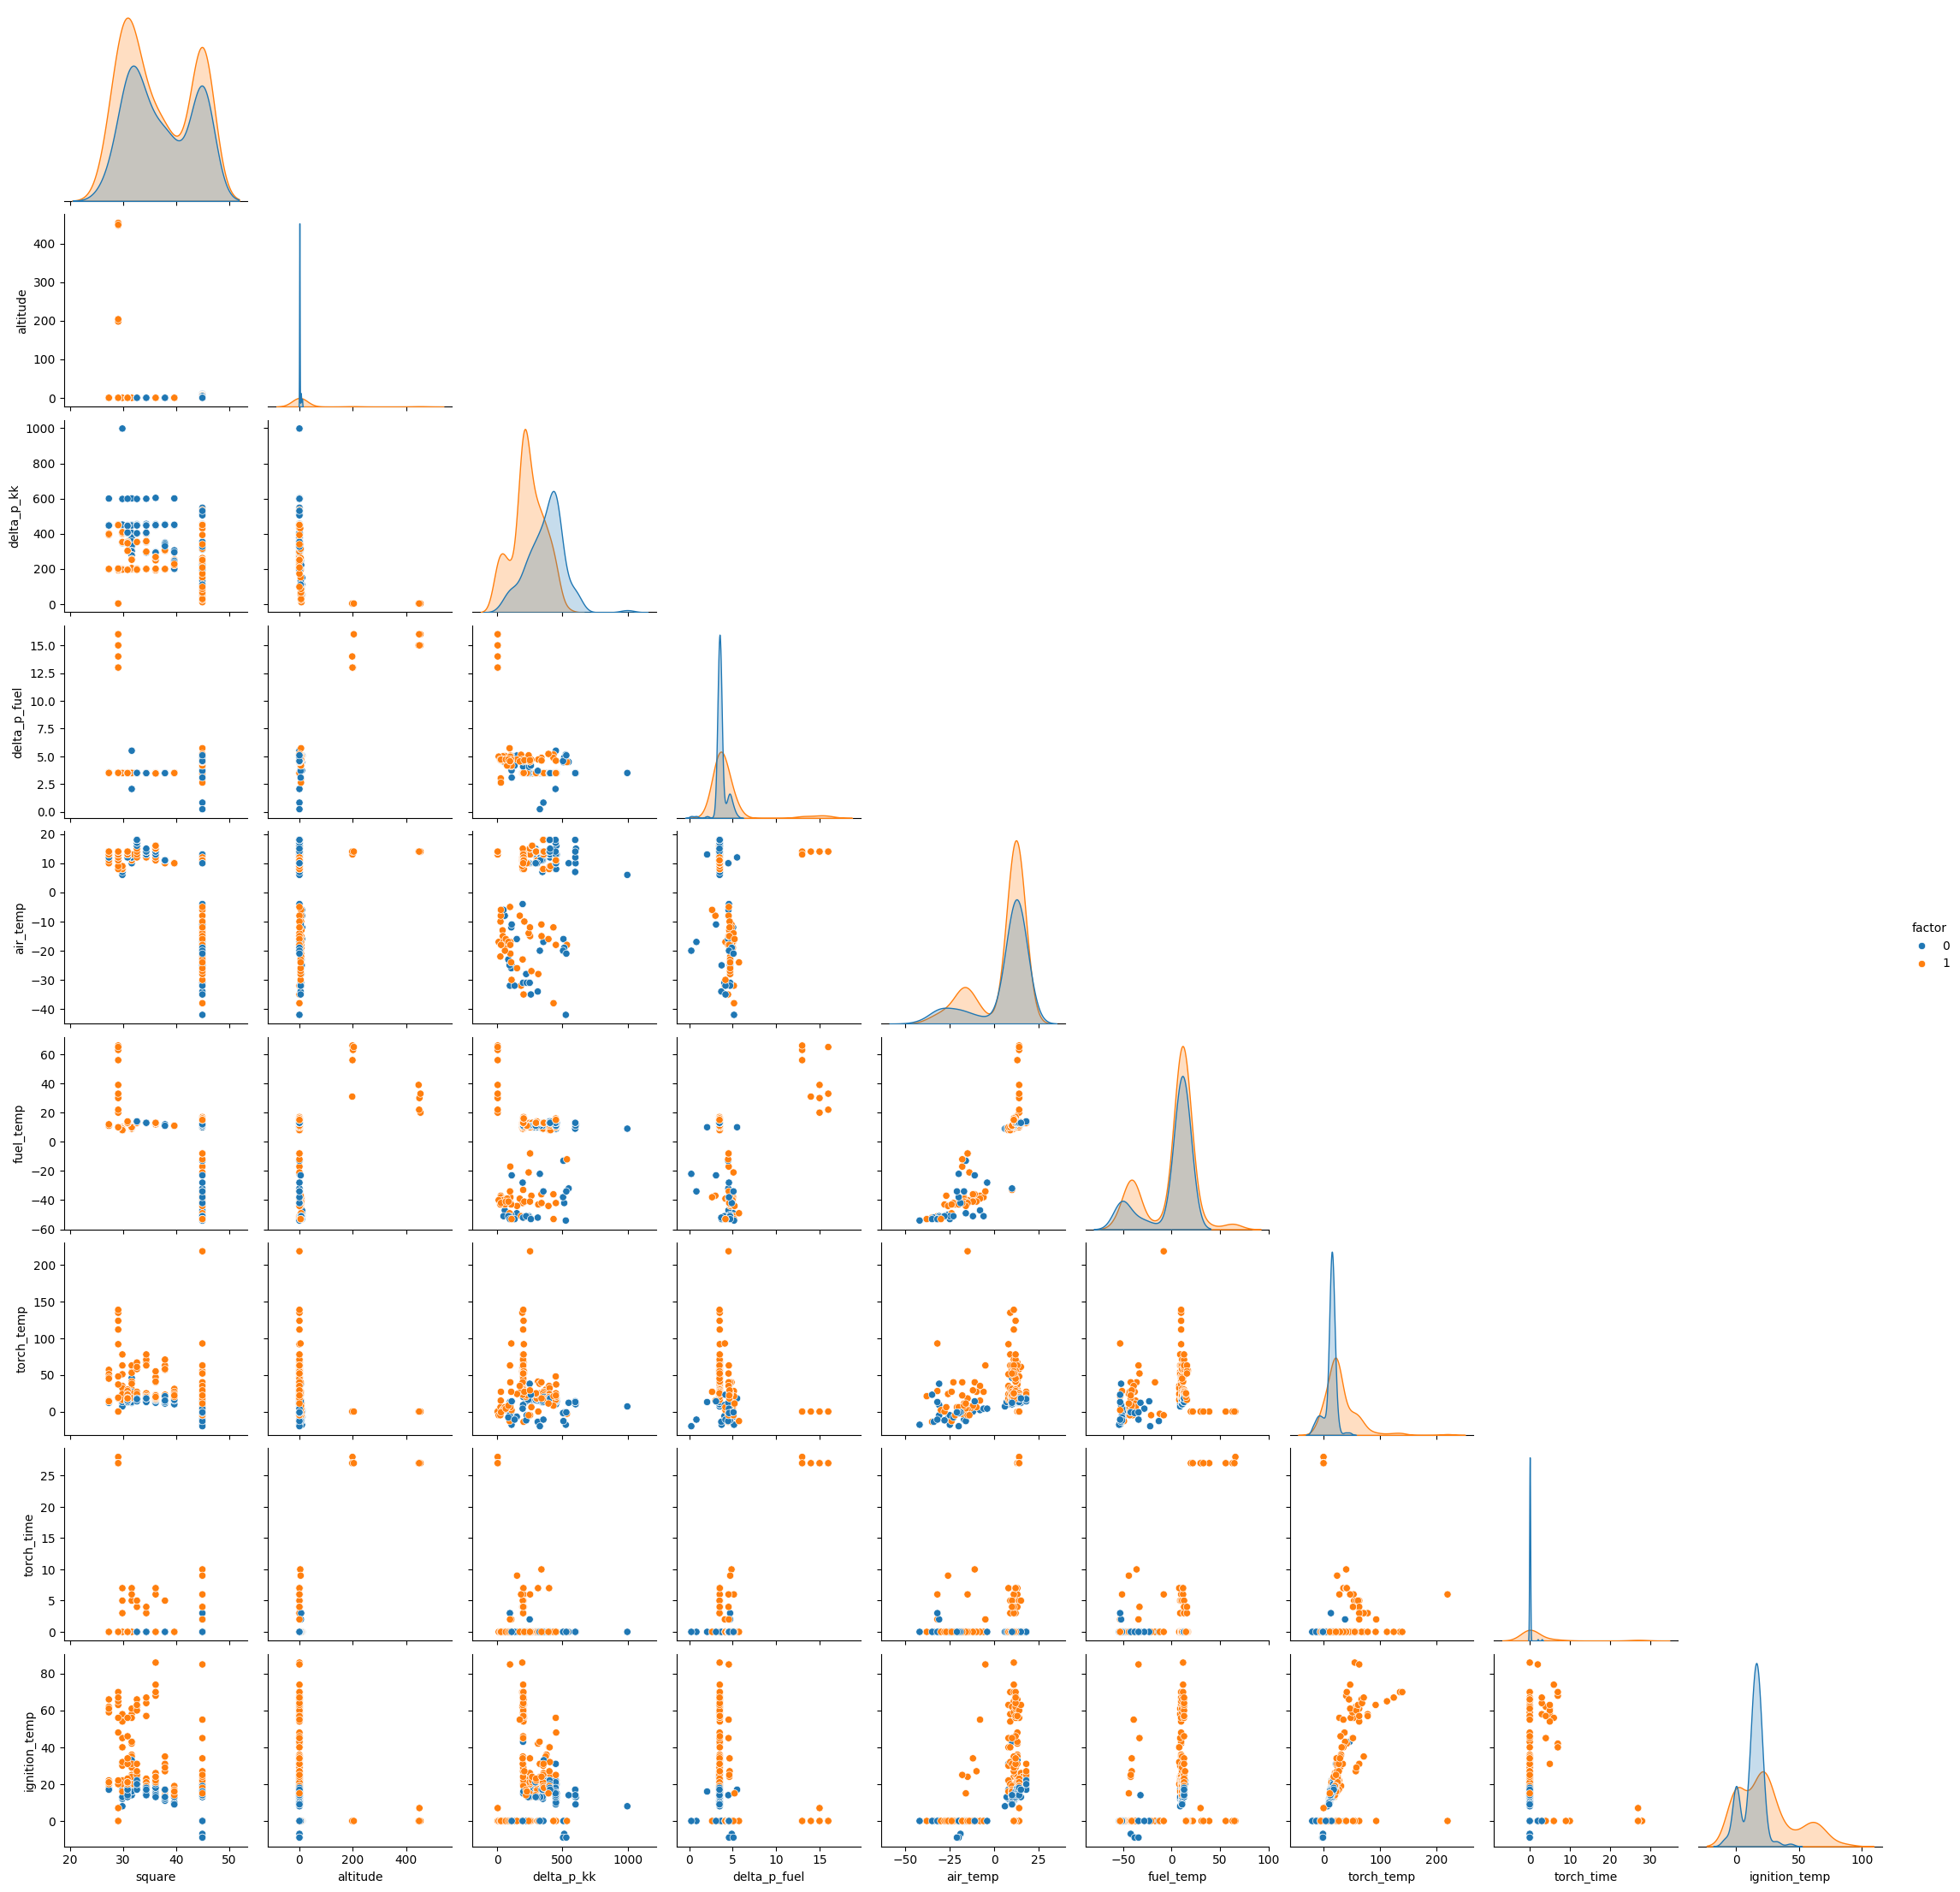

In [107]:
seaborn.pairplot(data_frame, vars=data_frame.columns[:-1], hue='factor', corner=True)
pyplot.show()

__t-SNE (t-distributed Stochastic Neighbor Embedding)__ — это нелинейный метод снижения размерности, который часто используют для визуализации многомерных данных в 2D или 3D пространстве. Он особенно полезен, когда нужно понять, есть ли в данных какие-то кластеры или группы, которые классическая линейная PCA может не так чётко выявить.
Основная польза t-SNE-визуализации — наглядно показать:

    - Существуют ли естественные подгруппы/кластеры в данных.
    
    - Смешиваются ли классы (0/1) в одних и тех же кластерах или чётко разделяются.
    
    - Насколько сложно (или легко) может быть отделить один класс от другого, если в кластерах царит «хаос» из точек разных цветов — значит, признаки не дают прямого 
    разделения.

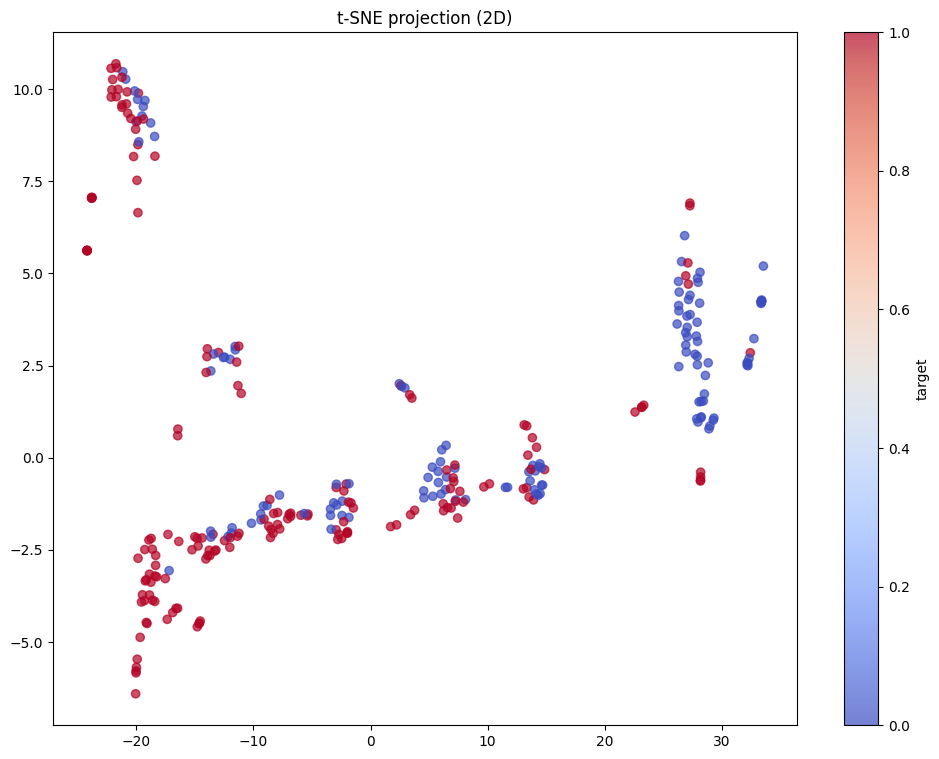

In [108]:
data_labels = data_frame['factor']
data = data_frame.drop(columns=['factor'])

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=3000)
X_tsne = tsne.fit_transform(data)

plt.figure(figsize=(12, 9))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=data_labels, cmap='coolwarm', alpha=0.7)
plt.title('t-SNE projection (2D)')
plt.colorbar(label='target')
plt.show()

In [110]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px

tsne_3d = TSNE(n_components=3, perplexity=30, random_state=42, max_iter=3000)
X_tsne_3d = tsne_3d.fit_transform(data)

df_3d = pandas.DataFrame(X_tsne_3d, columns=['tsne_x', 'tsne_y', 'tsne_z'])
df_3d['factor'] = data_labels

fig = px.scatter_3d(
    df_3d,
    x='tsne_x',
    y='tsne_y',
    z='tsne_z',
    color='factor',
    title='t-SNE in 3D (Plotly)',
    opacity=0.7
)

fig.update_traces(marker=dict(size=4))  # Размер маркеров
fig.show()


# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(111, projection='3d')
# x_3d = X_tsne_3d[:, 0]
# y_3d = X_tsne_3d[:, 1]
# z_3d = X_tsne_3d[:, 2]

# scatter = ax.scatter(x_3d, y_3d, z_3d, c=data_labels, cmap='coolwarm', alpha=0.7)

# ax.set_title('t-SNE (3D) projection')
# ax.set_xlabel('t-SNE axis 1')
# ax.set_ylabel('t-SNE axis 2')
# ax.set_zlabel('t-SNE axis 3')

# cbar = plt.colorbar(scatter, ax=ax, shrink=0.5)
# cbar.set_label('Target label')  # 0/1 или что-то другое

# plt.show()



